<a href="https://colab.research.google.com/github/szezlong/Titanic_Disaster_Analysis/blob/main/Titanic_DT_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Disaster Analysis:
Dane do analizy Titanic:
 https://www.kaggle.com/c/titanic/overview

## Cel:
* Budowac model do przewidywania przeżycie pasażera.
* Znależć istotne atrybuty, które mają wpływ na decyzję modelu.

### Konfiguracja środowiska

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
!pip install scikit-optimize -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.1 MB/s eta 0:00:00


### Dataset

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle competitions download -c titanic

!unzip "titanic.zip"

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 17.2MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Wstępna analiza danych
Wstępna analiza danych: liczba rekordów, liczba kolumn, rozkład decyzji. znaczenie kolumn. Czy są wartości nulowe?

####Czyszczenie danych i inżynieria cech


*   Atrybut Embarkment points został przekształcony na boolean.
* Atrybut Sex został przekształcony na boolean (is_male = 1).
* Uzupełniono wartości nullowe dla atrybutu age: NaN = 100.
*   Ponieważ atrybut Cabin jest nullowy dla 77% rekordów, zamieniono tę kolumnę na atrybut has_cabin, świadczący o tym, czy rekord zawiera informację o numerze kabiny



In [ ]:
print(f"Liczba rekordów: {df.shape[0]}")
print(f"Liczba kolumn: {df.shape[1]}\n")
print(f"Wartości nullowe:\n{df.isnull().sum()}")

Liczba rekordów: 891
Liczba kolumn: 12

Wartości nullowe:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
titanic_df = df.copy()

# One-hot encoding for embarkment
for k in titanic_df.Embarked.unique():
    if type(k)==str:
        titanic_df['emb_' + k] = (titanic_df.Embarked==k)*1

# For sex boolean
titanic_df['is_male'] = (titanic_df.Sex=='male')*1

# Has cabin boolean
titanic_df.loc[:, 'has_cabin'] = 1
titanic_df.loc[titanic_df.Cabin.isna(), 'has_cabin'] = 0

# Age fill
print(titanic_df['Age'].max())
titanic_df.loc[titanic_df.Age.isna(), 'Age'] = 100

titanic_df = titanic_df.drop(['Name', 'Sex', 'Cabin', 'Ticket', 'Embarked'], axis=1)
print(list(titanic_df))
titanic_df.head()

80.0
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'emb_S', 'emb_C', 'emb_Q', 'is_male', 'has_cabin']


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,emb_S,emb_C,emb_Q,is_male,has_cabin
0,1,0,3,22.0,1,0,7.2500,1,0,0,1,0
1,2,1,1,38.0,1,0,71.2833,0,1,0,0,1
2,3,1,3,26.0,0,0,7.9250,1,0,0,0,0
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,0,1,0


In [ ]:
print(f"Wartości nullowe:\n{titanic_df.isnull().sum()}")

Wartości nullowe:
PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
emb_S          0
emb_C          0
emb_Q          0
is_male        0
has_cabin      0
dtype: int64


####Wstępna analiza danych

##### Data Dictionary

|Variable|Definition|Key|
| --- | --- |:---|
| passengerId | Passenger's Id | |
| survived | Whether survived | 0 = No, 1 = Yes |
| pclass	| Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex	| Sex | |
| age | Age in years | |
| sibsp	| # of siblings / spouses aboard the Titanic | 	|
| parch	| # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare	| Passenger fare | 	|
| emb_x | Whether they embarked from C /Q /S | C = Cherbourg (France), Q = Queenstown (Ireland), S = Southampton (England) |
| is_male | Whether they are male | 0 = No, 1 = Yes |
| has_cabin | Whether they have a cabin | 0 = No, 1 = Yes |

In [ ]:
print(f"Liczba rekordów: {titanic_df.shape[0]}")
print(f"Liczba kolumn: {titanic_df.shape[1]}\n")

print(f"Rozkład decyzji (przeżycie):\n{titanic_df['Survived'].value_counts()}\n")

print(f"Znaczenie kolumn:\n{titanic_df.describe()}\n")

print(f"Wartości nullowe:\n{titanic_df.isnull().sum()}")

Liczba rekordów: 891
Liczba kolumn: 12

Rozkład decyzji (przeżycie):
Survived
0    549
1    342
Name: count, dtype: int64

Znaczenie kolumn:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   43.664613    0.523008   
std     257.353842    0.486592    0.836071   30.930373    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   32.000000    0.000000   
75%     668.500000    1.000000    3.000000   54.000000    1.000000   
max     891.000000    1.000000    3.000000  100.000000    8.000000   

            Parch        Fare       emb_S       emb_C       emb_Q     is_male  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.381594   32.204208    0.722783    0.188552    0.086420 

Text(0.5, 1.0, 'Survival by age')

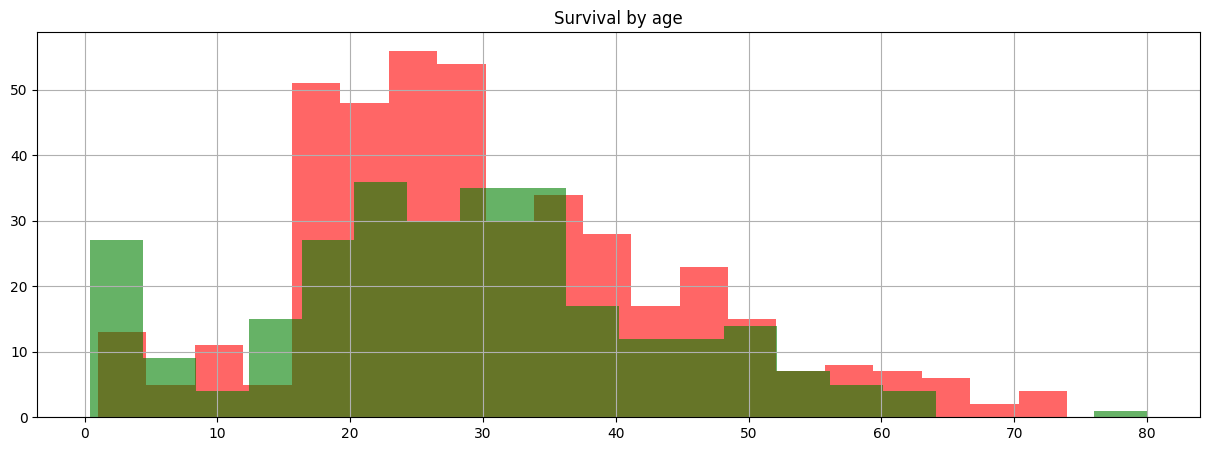

In [ ]:
titanic_df.loc[(titanic_df.Survived==0) & (titanic_df.Age != 100), 'Age'].hist(bins=20, alpha=.6, color='red', figsize=[15, 5])
titanic_df.loc[(titanic_df.Survived==1) & (titanic_df.Age != 100), 'Age'].hist(bins=20, alpha=.6, color='green')
plt.title('Survival by age')

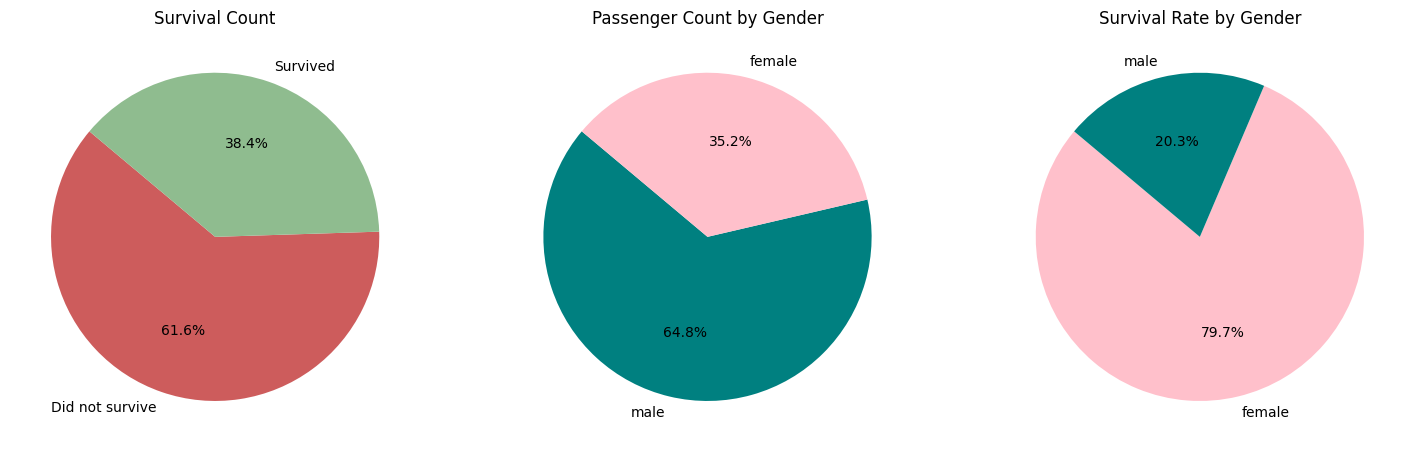

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].pie(titanic_df['Survived'].value_counts(), labels=['Did not survive', 'Survived'], autopct='%1.1f%%', startangle=140, colors=['indianred', 'darkseagreen'])
axes[0].set_title('Survival Count')

axes[1].pie(titanic_df['is_male'].value_counts(),
            labels=['female' if x == 0 else 'male' for x in titanic_df['is_male'].value_counts().index],
            autopct='%1.1f%%', startangle=140,
            colors=['teal', 'pink'])
axes[1].set_title('Passenger Count by Gender')

survival_rate_by_gender = titanic_df[['is_male', 'Survived']].groupby('is_male').agg(['mean', 'count'])
axes[2].pie(survival_rate_by_gender['Survived']['mean'],
            labels=['male' if x == 1 else 'female' for x in survival_rate_by_gender['Survived']['mean'].index],
            autopct='%1.1f%%', startangle=140,
            colors=['pink', 'teal'], normalize=True)
axes[2].set_title('Survival Rate by Gender')


plt.show()

## Decision Tree:
Trenować drzewo decyzyjne, ustawić parametry, żeby maksymalizować *trafność modelu* (*accuracy*)  

###Trenowanie modelu

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
X = titanic_df.copy()
y = X.pop('Survived')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(668, 11)
(223, 11)


In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

####Walidacja modelu

In [ ]:
y_pred_train = dt.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)

y_pred_test = dt.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

Train Accuracy: 1.0
Test Accuracy: 0.7219730941704036


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

Confusion Matrix:
[[97 37]
 [25 64]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       134
           1       0.63      0.72      0.67        89

    accuracy                           0.72       223
   macro avg       0.71      0.72      0.72       223
weighted avg       0.73      0.72      0.72       223



###Maksymalizacja accuracy modelu

In [ ]:
params = {
    'criterion':  ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth':  [None, 2, 4, 6, 8, 10, 12, 14],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 4, 6],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}],
}

grid_search  = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    scoring='accuracy',
    n_jobs=5,
    verbose=1,
)

grid_search .fit(X_train, y_train)
print(grid_search .best_params_)

Fitting 5 folds for each of 8064 candidates, totalling 40320 fits
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}


####Walidacja ostatecznego modelu

In [ ]:
dt_best = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8, max_features=0.6, min_samples_leaf=8, min_samples_split= 2, splitter='random')
dt_best.fit(X_train, y_train)

y_pred_best_train = dt_best.predict(X_train)
accuracy_best_train = accuracy_score(y_train, y_pred_best_train)
print("Train Accuracy:", accuracy_best_train)

y_pred_best_test = dt_best.predict(X_test)
accuracy_best_test = accuracy_score(y_test, y_pred_best_test)
print("Test Accuracy:", accuracy_best_test)

Train Accuracy: 0.8173652694610778
Test Accuracy: 0.8161434977578476


Test Accuracy wzrosło z 0.722 do 0.816


In [ ]:
cv_scores_best = cross_val_score(dt_best, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores_best)
print("Mean CV Score:", cv_scores_best.mean())

Cross-Validation Scores: [0.7761194  0.86567164 0.78358209 0.73684211 0.87969925]
Mean CV Score: 0.8083828975423634


In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_stratified_best = cross_val_score(dt_best, X_train, y_train, cv=stratified_kfold)
print("Stratified K-Fold Cross-Validation Scores:", cv_scores_stratified_best)
print("Mean Stratified K-Fold CV Score:", cv_scores_stratified_best.mean())

Stratified K-Fold Cross-Validation Scores: [0.7761194  0.86567164 0.76865672 0.80451128 0.81954887]
Mean Stratified K-Fold CV Score: 0.8069015823139939


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_test))

Confusion Matrix:
[[122  12]
 [ 29  60]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_best_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       134
           1       0.83      0.67      0.75        89

    accuracy                           0.82       223
   macro avg       0.82      0.79      0.80       223
weighted avg       0.82      0.82      0.81       223



## XGBClassifier:
Trenować wybrany ensemble model, żeby maksymalizować *trafność* .

In [ ]:
X_xgb = titanic_df.copy()
y_xgb = X_xgb.pop('Survived')
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, random_state = 12)

print(X_train_xgb.shape)
print(X_test_xgb.shape)

(668, 11)
(223, 11)


In [ ]:
from xgboost import XGBClassifier

params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300],
    'random_state': [42],
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=params,
    cv=5,
    scoring='accuracy',
    n_jobs=5,
    verbose=1,
)

grid_search_xgb.fit(X_train_xgb, y_train_xgb)
print(grid_search_xgb.best_params_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'random_state': 42, 'subsample': 1.0}


In [ ]:
xgb = XGBClassifier(colsample_bytree= 0.8, learning_rate= 0.05, max_depth= 5, n_estimators= 100, random_state= 42, subsample= 1)
xgb.fit(X_train_xgb, y_train_xgb)

y_pred_xgb_train = xgb.predict(X_train_xgb)
accuracy_xgb_train = accuracy_score(y_train_xgb, y_pred_xgb_train)
print("Train Accuracy:", accuracy_xgb_train)

y_pred_xgb_test = xgb.predict(X_test_xgb)
accuracy_xgb_test = accuracy_score(y_test_xgb, y_pred_xgb_test)
print("Test Accuracy:", accuracy_xgb_test)

Train Accuracy: 0.9131736526946108
Test Accuracy: 0.7847533632286996


In [ ]:
cv_scores_xgb = cross_val_score(xgb, X_train_xgb, y_train_xgb, cv=5)
print("Cross-Validation Scores:", cv_scores_xgb)
print("Mean CV Score:", cv_scores_xgb.mean())

Cross-Validation Scores: [0.78358209 0.88059701 0.8880597  0.80451128 0.85714286]
Mean CV Score: 0.8427785882616989


In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_stratified_xgb = cross_val_score(xgb, X_train_xgb, y_train_xgb, cv=stratified_kfold)
print("Stratified K-Fold Cross-Validation Scores:", cv_scores_stratified_xgb)
print("Mean Stratified K-Fold CV Score:", cv_scores_stratified_xgb.mean())

Stratified K-Fold Cross-Validation Scores: [0.82835821 0.80597015 0.86567164 0.84210526 0.87969925]
Mean Stratified K-Fold CV Score: 0.8443609022556391


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_xgb, y_pred_xgb_test))

Confusion Matrix:
[[118  12]
 [ 36  57]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test_xgb, y_pred_xgb_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       130
           1       0.83      0.61      0.70        93

    accuracy                           0.78       223
   macro avg       0.80      0.76      0.77       223
weighted avg       0.79      0.78      0.78       223



## Analiza drzewa i wnioski:  
Podać, które atrybuty są istotne (analizując random forest)
Wkazówka: atrybuty znajdują się blisko korzenia są ważniejsze niż te, które znajdują się daleko korzenia.

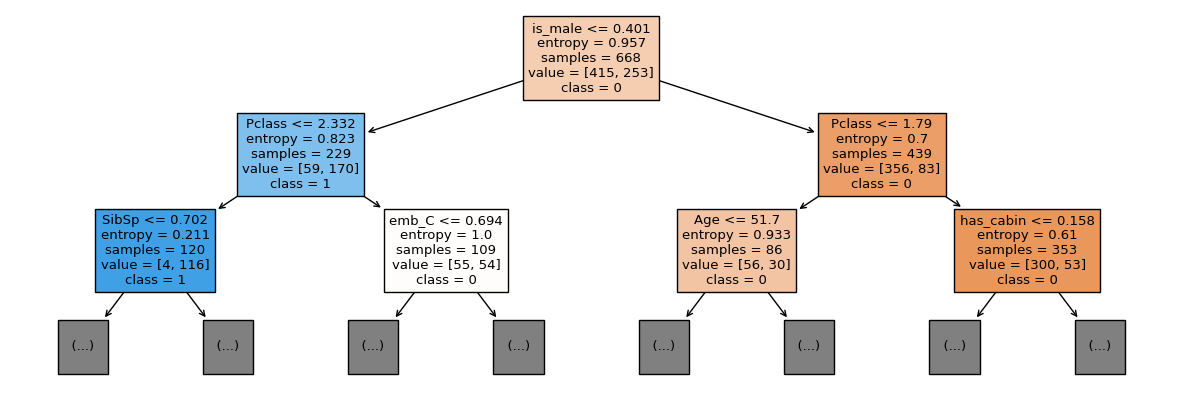

In [ ]:
fig = plt.figure(figsize=(15, 5))

t_names = ["0", "1"]
tree.plot_tree(dt_best, max_depth=2, feature_names=X.columns.tolist(), class_names=t_names, filled=True)

plt.show()

In [ ]:
from sklearn.tree import export_text

r = export_text(dt_best, feature_names=X.columns.tolist(), max_depth=2)
print(r)

|--- is_male <= 0.40
|   |--- Pclass <= 2.33
|   |   |--- SibSp <= 0.70
|   |   |   |--- truncated branch of depth 2
|   |   |--- SibSp >  0.70
|   |   |   |--- truncated branch of depth 3
|   |--- Pclass >  2.33
|   |   |--- emb_C <= 0.69
|   |   |   |--- truncated branch of depth 2
|   |   |--- emb_C >  0.69
|   |   |   |--- class: 1
|--- is_male >  0.40
|   |--- Pclass <= 1.79
|   |   |--- Age <= 51.70
|   |   |   |--- truncated branch of depth 3
|   |   |--- Age >  51.70
|   |   |   |--- truncated branch of depth 4
|   |--- Pclass >  1.79
|   |   |--- has_cabin <= 0.16
|   |   |   |--- truncated branch of depth 6
|   |   |--- has_cabin >  0.16
|   |   |   |--- class: 1



###Wnioski
Na podstawie drzewa decyzyjnego (RandomForest), można wyciągnąć następujące wnioski:

1. **Płeć (`is_male`)**:
   - Płeć jest najbardziej kluczowym czynnikiem decyzyjnym. Jeśli pasażer jest kobietą (wartość `is_male <= 0.40`), to prawdopodobieństwo przeżycia jest wyższe.

2. **Klasa biletu (`Pclass`)**:
   - Klasa biletu również wydaje się być istotnym czynnikiem. Pasażerowie z wyższą klasą biletu mają większe szanse na przeżycie.

3. **Liczba rodzeństwa/ małżonków na pokładzie (`SibSp`)**:
   - Liczba rodzeństwa/ małżonków na pokładzie wydaje się mieć wpływ na predykcję, choć nie jest to tak wyraźnie widoczne. Mogą istnieć pewne interakcje z innymi atrybutami, takimi jak płeć i klasa biletu.

4. **Wiek (`Age`)**:
   - Wiek również jest brany pod uwagę, ale nie wydaje się być tak istotny jak płeć i klasa biletu. Istnieje widoczne ograniczenie wiekowe w niektórych gałęziach drzewa, co sugeruje, że młodsi pasażerowie mogą mieć wyższe szanse na przeżycie w niektórych przypadkach (zwłaszcza biorąc pod uwagę wykres przeżywalności w zależności od wieku).

5. **Posiadanie kabiny (`has_cabin`)**:
   - Posiadanie kabiny również ma wpływ na predykcję. W niektórych przypadkach pasażerowie posiadający kabinę mają większe szanse na przeżycie.

6. **Port wejścia na pokład (`emb_C`)**:
   - Dodatkowo, wygląda na to, że pasażerowie, którzy wsiadali z Cherbourga (Francja), mogą mieć większe szanse na przeżycie, jeśli inne czynniki, takie jak płeć i klasa biletu, również wspierają tę decyzję.